In [61]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [62]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [63]:
chs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [64]:
import random
random.seed(42)
random.shuffle(words)

In [65]:
block_size = 8
# -- build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        # print(w)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[c] for c in context), "-->", ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [105]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
    def __init__(self, num_embedding, emb_dimension):
        self.weight = torch.randn((num_embedding, emb_dimension))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [106]:
torch.manual_seed(42)

In [107]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False),      BatchNorm1d(n_hidden),      Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in model.parameters():
  p.requires_grad = True

22097


In [108]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #mini batch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update, simple SGD
    lr = 0.1 if i < 150000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())


      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


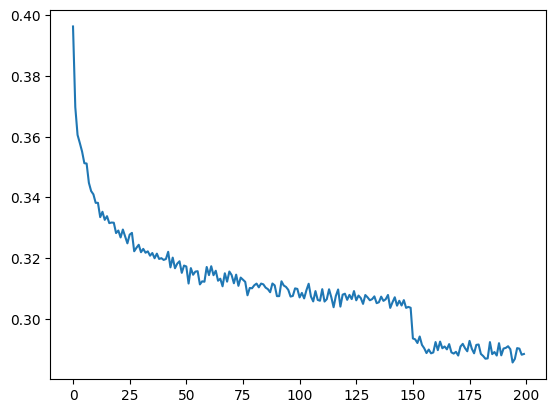

In [109]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [110]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [111]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.9163435697555542
dev 2.034247875213623


In [112]:
# sample generation

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))


melae.
lynn.
gwesen.
macoy.
delia.
chrelan.
jaquin.
dayana.
haziyah.
hamilin.
